In [4]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Markdown

import warnings

warnings.filterwarnings('ignore')
sns.set_context('talk')
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)

In [5]:
# Funções Helpers

def selecionar_ativo(TICKER, SUAVIZAR=False, DIST_ALVO=5, ENTRADA_SAIDA_MODELO='Close'):
    """### Descrição:
    Baixa os dados do ticker do Yahoo Finance e computa automaticamente o alvo de acordo com a distância presente no
    parâmetro DIST_ALVO. O alvo é binário, considerado como subiu ou caiu, será 1 quando o retorno for maior que 0.

    ### Notas:
    - !!CASO UTILIZAR A ENTRADA COMO "Open" TERÁ VAZAMENTO DE DADOS!!;
    - O retorno não leva em conta a distribuição de dividendos;
    - O retorno não leva em conta o split de ações.

    ### Args:
        TICKER (str): Ticker do Yahoo Finance.
        SUAVIZAR (bool, optional): Suaviza os dados OHLC com uma média móvel com alpha de 0,5. Defaults to False.
        DIST_ALVO (int, optional): Número de dias no futuro para o retorno ser calculado, ou seja, o tempo que se permanece
        na operação. Defaults to 1.
        ENTRADA_SAIDA_MODELO (str, optional): "Open" ou "Close", é a entrada do modelo. Defaults to 'Close'.

    ### Returns:
        pandas.Dataframe: Retorna um dataframe com dados OHLC, retorno e alvo.
    """

    import pandas as pd
    import yfinance as yf

    ticker = yf.Ticker(TICKER) 

    df = ticker.history(
        start='2017-01-01',
        end='2022-06-01',
        interval='1d',
    ).reset_index()

    assert DIST_ALVO > 0, 'O número de dias paro o alvo precisa ser maior ou igual a zero.'
    assert ENTRADA_SAIDA_MODELO in ['Open', 'Close'], 'A entrada e saída do modelo precisa ser igual a "Open" ou "Close".'

    df['LEAK_Retorno'] = (df[ENTRADA_SAIDA_MODELO].shift(-DIST_ALVO) - df[ENTRADA_SAIDA_MODELO])/df[ENTRADA_SAIDA_MODELO].shift(-DIST_ALVO)
    df['Alvo'] = (df['LEAK_Retorno'] > 0.00).astype('int')


    if SUAVIZAR == True:
        ALPHA_FACTOR = .5
        df['Open'] = df.Open.ewm(alpha=ALPHA_FACTOR).mean()
        df['Close'] = df.Close.ewm(alpha=ALPHA_FACTOR).mean()
        df['High'] = df.High.ewm(alpha=ALPHA_FACTOR).mean()
        df['Low'] = df.Low.ewm(alpha=ALPHA_FACTOR).mean()

    return df


def get_wiki_pageviews(PAGE, df):
    """Fonte: https://wikimedia.org/api/rest_v1/

    Args:
        PAGE (str): Final da URL da página da Wikipedia.
        df (pandas.DataFrame): Dataframe a ser enriquecido com dados de visualização do Wikipedia.

    Returns:
        pandas.DataFrame: Dataframe enriquecido com dados da Wikipedia
    """

    import random
    import requests
    import json
    import pandas as pd
    
    # Período analisado
    DATEMIN = df.Date.dt.strftime('%Y%m%d').min()
    DATEMAX = df.Date.dt.strftime('%Y%m%d').max()

    # Endpoint da API
    URL = f'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/pt.wikipedia.org/all-access/all-agents/{PAGE}/daily/{DATEMIN}/{DATEMAX}'

    USER_AGENTS = [
        'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.81 Safari/537.36',
        'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36',
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.127 Safari/537.36',
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.67 Safari/537.36',
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.102 Safari/537.36',
        'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/52.0.2743.116 Safari/537.36',
    ]   

    response = requests.get(
        URL,
        headers={"user-agent" : random.choice(USER_AGENTS)}
    )

    content_json = json.loads(response.content)
    results_df = pd.DataFrame.from_dict(content_json['items'])[['timestamp', 'views']]
    results_df['timestamp'] = pd.to_datetime([x[:-2] for x in results_df.timestamp])

    results_df = results_df.rename({'views': 'WIKI_daily_views', 'timestamp': 'Date'}, axis=1)

    final_df = df[:]
    final_df = final_df.merge(right=results_df, on='Date')

    return final_df

    
def wiki_indicators(pagina_wiki, df):
    """TODO

    Args:
        pagina_wiki (str): TODO
        df (pandas.DataFrame): TODO

    Returns:
        pandas.DataFrame: TODO
    """    
    
    df_copy = df[:]
    df_copy = get_wiki_pageviews(pagina_wiki, df_copy)

    df_copy['WIKI_SMA_5'] = df_copy['WIKI_daily_views'].rolling(5).mean()
    df_copy['WIKI_SMA_5_Distance'] = df_copy['WIKI_daily_views'] - df_copy['WIKI_SMA_5']
    df_copy['WIKI_Yesterday_diff'] = df_copy['WIKI_daily_views'] - df_copy['WIKI_daily_views'].shift(-1)
    df_copy['WIKI_ROC_5'] = ((df_copy['WIKI_daily_views'] / df_copy['WIKI_SMA_5']) - 1) * 100

    return df_copy


def forward_shift(df, col, list_shift):

    df_copy = df[:]

    for shift in list_shift:
        df_copy[f'{col}_shift{shift:>02}'] = df_copy[col].shift(-shift)

    return df_copy


# Integridade do Dataset

A função *selecionar_ativo* faz uma requisição a API do Yahoo Finance e computa automaticamente o alvo de acordo com a distância escolhida:
> **Distância do alvo:** é o número de dias no futuro usado para calcular o retorno, por exemplo, para uma distância de 5, o retorno será calculado com base no preço fechamento de hoje e no fechamento daqui 5 dias.  
> **Alvo:** como nosso objetivo é predizer a direção do ativo, ou seja, se ele irá subir ou cair nosso alvo é binário e calculado a partir do retorno levando em conta a distância do alvo, caso for superior a 0, será 1, inferior, 0.

Não se espera valores nulos a não ser para o retorno das últimas *n* linhas, sendo *n* a distância do alvo.

In [6]:
df = selecionar_ativo('PETR4.SA', DIST_ALVO=5)

In [7]:
df.isna().sum()

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
LEAK_Retorno    5
Alvo            0
dtype: int64

Como esperado, 5 valores nulos para o retorno. Essas linhas precisam ser removidas. Após essa EDA a função já irá remover automaticamente esses valores nulos.

In [8]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,LEAK_Retorno,Alvo
count,1346.000000,1346.000000,1346.000000,1346.000000,1.346000e+03,1346.000000,1346.0,1341.000000,1346.000000
mean,12.766286,12.950656,12.567289,12.753180,6.325418e+07,0.010549,0.0,0.002134,0.580238
std,4.222275,4.277657,4.167393,4.225609,3.542316e+07,0.165995,0.0,0.072302,0.493703
min,5.922791,6.048700,5.837173,5.862355,0.000000e+00,0.000000,0.0,-1.007143,0.000000
25%,9.277876,9.408974,9.023793,9.249633,4.065282e+07,0.000000,0.0,-0.021053,0.000000
50%,12.899673,13.099890,12.686609,12.879515,5.567335e+07,0.000000,0.0,0.009253,1.000000
75%,15.350732,15.503421,15.103605,15.289593,7.622610e+07,0.000000,0.0,0.036603,1.000000
max,26.179411,26.532178,26.016552,26.451799,4.902304e+08,3.715490,0.0,0.211592,1.000000


Verificaremos se para todos os dias úteis, a função nos trouxe os dados de OHLCV do ativo.

In [9]:
DIAS_UTEIS = pd.DataFrame(pd.date_range(start='2017-01-01', end='2022-05-31', freq='b'), columns=['D_Util'])

CHECK_INTEGRIDADE = DIAS_UTEIS.merge(df, left_on='D_Util', right_on='Date', how='left', indicator=True)

print(len(CHECK_INTEGRIDADE.query('_merge == "left_only"')))

66


Ao todo 66 dias úteis não constam no dataset, note que alguns desses dias são feriados, iremos realizar o mesmo teste para 3 ativos distintos e verificar se o problema foi a requisição ou se ocorre para todos os casos.

In [10]:
def test_integrity_check(TICKER_LIST):

    def integriy_check(TICKER):

        df = selecionar_ativo(TICKER, DIST_ALVO=5)

        DIAS_UTEIS = pd.DataFrame(pd.date_range(start='2017-01-01', end='2022-05-31', freq='b'), columns=[f'D_Util_{TICKER}'])
        CHECK_INTEGRIDADE = DIAS_UTEIS.merge(df, left_on=f'D_Util_{TICKER}', right_on='Date', how='left', indicator=True)
        DIAS_N_PRESENTES = CHECK_INTEGRIDADE.query('_merge == "left_only"')[[f'D_Util_{TICKER}']]

        return DIAS_N_PRESENTES

    
    INTEGRITY_TEST = pd.DataFrame()

    for TICKER in TICKER_LIST:

        INTEGRITY_TEST = pd.concat([INTEGRITY_TEST, integriy_check(TICKER)], axis=1)


    BASIS = INTEGRITY_TEST.columns[0]
    for col in INTEGRITY_TEST.columns[1:]:

        if (INTEGRITY_TEST[BASIS] != INTEGRITY_TEST[col]).any():
            print(f'Problema de Integridade: {BASIS} é diferente de {col}')
        else:
            print(f'Os mesmos dias faltantes para {BASIS} são os de {col}')


    return INTEGRITY_TEST

In [11]:
int_check = test_integrity_check(['PETR4.SA', 'CMIG3.SA', 'MGLU3.SA'])

Os mesmos dias faltantes para D_Util_PETR4.SA são os de D_Util_CMIG3.SA
Os mesmos dias faltantes para D_Util_PETR4.SA são os de D_Util_MGLU3.SA


---

#  Indicadores Técnicos

## RSI (Relative Strengh Index)

- O RSI é um indicador de *momentum* usado na análise técnica, ele mede a velocidade e magnitude das mudanças recentes no preço dos ativos para avaliar condições de **Sobrecompra** e **Sobrevenda**;

- Sua escala é limitada entre 0 e 100;

- Como regra de dedo, um RSI acima de 70 indica um mercado sobrecomprado, ou seja, estamos perto de uma correção ou virada de tendência para baixo, e abaixo de 30 indica um mercado sobrevendido que segue uma lógica similar.

In [12]:
df = selecionar_ativo('MGLU3.SA', DIST_ALVO=5)

df['RSI_14'] = df.ta.rsi()

df['FLG_RSI_Sobrecomprado'] = df[f'RSI_14'] > 70
df['FLG_RSI_Sobrevendido'] = df[f'RSI_14'] < 30

df = df.dropna()

Verificaremos a estratégia mais comum usada em conjunto com o indicador técnico RSI, observando a média do retorno e a média da direção do ativo.

Para o RSI sobrecomprado, ou seja, acima de 70, as estratégias plug and play ditam que é um momento de VENDER o ativo:

In [13]:
df.groupby('FLG_RSI_Sobrecomprado').agg({'LEAK_Retorno': 'mean', 'Alvo': 'mean'})

,LEAK_Retorno,Alvo
FLG_RSI_Sobrecomprado,,
False,0.002085,0.544978
True,0.020018,0.637363


Note que, quando o RSI está marcado como sobrecomprado o alvo de 5 dias tende a ser POSITIVO, ou seja, o RSI sobrecomprado para MGLU3 na verdade é um sinal de COMPRA, a direção completamente contrária das estratégias vendidas no mercado.

In [14]:
df.groupby('FLG_RSI_Sobrevendido').agg({'LEAK_Retorno': 'mean', 'Alvo': 'mean'})

,LEAK_Retorno,Alvo
FLG_RSI_Sobrevendido,,
False,0.005146,0.560250
True,-0.011138,0.489796


Para o RSI sobrevendido temos o cenário paralelo, para o RSI sobrevendido, temos um sinal de VENDA ao invés de compra.

Verificaremos se alterar a distância do alvo há um impacto na análise, podemos selecionar um ponto ótimo e criar uma estratégia usando apenas um único indicador.

In [15]:
def RSI_dist_alvo_optimizer(TICKER):


    RESULTADOS = pd.DataFrame(columns=['Distancia_Alvo', 'Media_Alvo_RSI_Sobrecomprado', 'Media_Alvo_Sobrecomprado',
                                       'Media_Alvo_RSI_Sobrevendido', 'Media_Alvo_Sobrevendido'])
    for index, i in enumerate(range(1, 21)):

        df = selecionar_ativo(TICKER, DIST_ALVO=i)
        df['RSI_14'] = df.ta.rsi()
        df['FLG_RSI_Sobrecomprado'] = df[f'RSI_14'] > 70
        df['FLG_RSI_Sobrevendido'] = df[f'RSI_14'] < 30
        
        rsi_sobrecomprado = df.groupby('FLG_RSI_Sobrecomprado').agg({'Alvo': 'mean'})
        rsi_sobrevendido = df.groupby('FLG_RSI_Sobrevendido').agg({'Alvo': 'mean'})

        RESULTADOS.loc[index, 'Distancia_Alvo'] = i
        RESULTADOS.loc[index, 'Media_Alvo_RSI_Sobrecomprado'] = rsi_sobrecomprado.loc[True, 'Alvo']
        RESULTADOS.loc[index, 'Media_Alvo_Sobrecomprado'] = rsi_sobrecomprado.loc[False, 'Alvo']
        RESULTADOS.loc[index, 'Media_Alvo_RSI_Sobrevendido'] = rsi_sobrevendido.loc[True, 'Alvo']
        RESULTADOS.loc[index, 'Media_Alvo_Sobrevendido'] = rsi_sobrevendido.loc[False, 'Alvo']

    
    return RESULTADOS

def RSI_dist_alvo_visualizer(RESULTADOS_OPTIMIZER):

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,8), sharex=True)

    sns.lineplot(
        data=RESULTADOS_OPTIMIZER,
        x='Distancia_Alvo',
        y='Media_Alvo_RSI_Sobrecomprado',
        ax=ax[0],
        label='Sobrecomprado'
    )
    sns.lineplot(
        data=RESULTADOS_OPTIMIZER,
        x='Distancia_Alvo',
        y='Media_Alvo_Sobrecomprado',
        ax=ax[0],
        label='Não sobrecomprado'
    )
    ax[0].set_title('Para o RSI Sobrecomprado')
    ax[0].set_ylabel('Proporção de dias que o ativo subiu')
    ax[0].legend(['Sobrecomprado', 'Não sobrecomprado'])

    sns.lineplot(
        data=RESULTADOS_OPTIMIZER,
        x='Distancia_Alvo',
        y='Media_Alvo_RSI_Sobrevendido',
        ax=ax[1],
        label='Sobrevendido'
    )
    sns.lineplot(
        data=RESULTADOS_OPTIMIZER,
        x='Distancia_Alvo',
        y='Media_Alvo_Sobrevendido',
        ax=ax[1],
        label='Não Sobrevendido'
    )
    
    ax[1].set_title('Para o RSI Sobrevendido')
    ax[1].set_ylabel('Proporção de dias que o ativo subiu')
    ax[1].set_xlabel('Distância do alvo')
    ax[1].set_xticks(range(2, 21, 2))
    ax[1].set_xlim(1, 20)


Analisaremos 3 ativos:
- PETR4
- CMIG3
- ITUB4

In [16]:
RSI_ALVO_PETR4 = RSI_dist_alvo_optimizer('PETR4.SA')
RSI_ALVO_CMIG3 = RSI_dist_alvo_optimizer('CMIG3.SA')
RSI_ALVO_ITUB4 = RSI_dist_alvo_optimizer('ITUB4.SA')

**Para PETR4:**

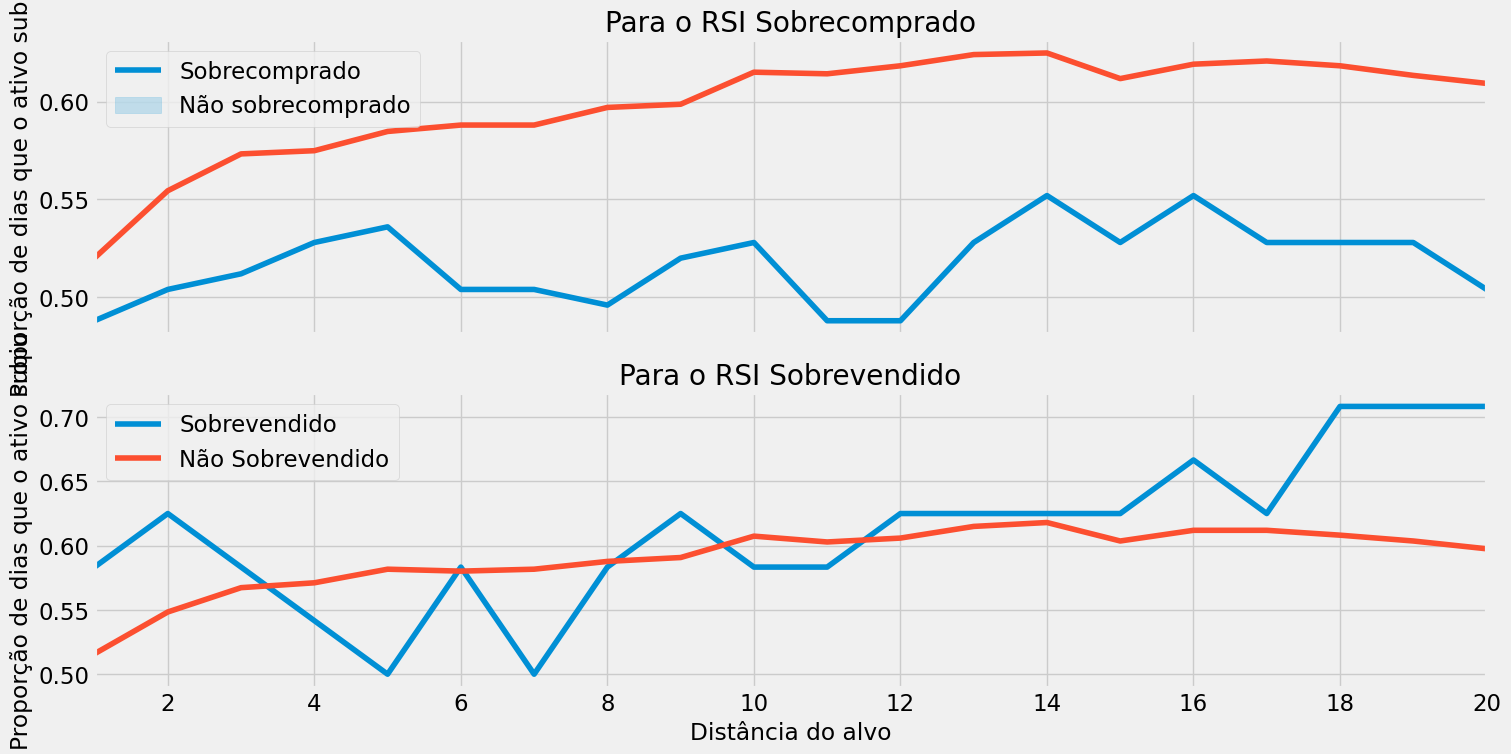

In [17]:
RSI_dist_alvo_visualizer(RSI_ALVO_PETR4)

**Para CMIG3:**

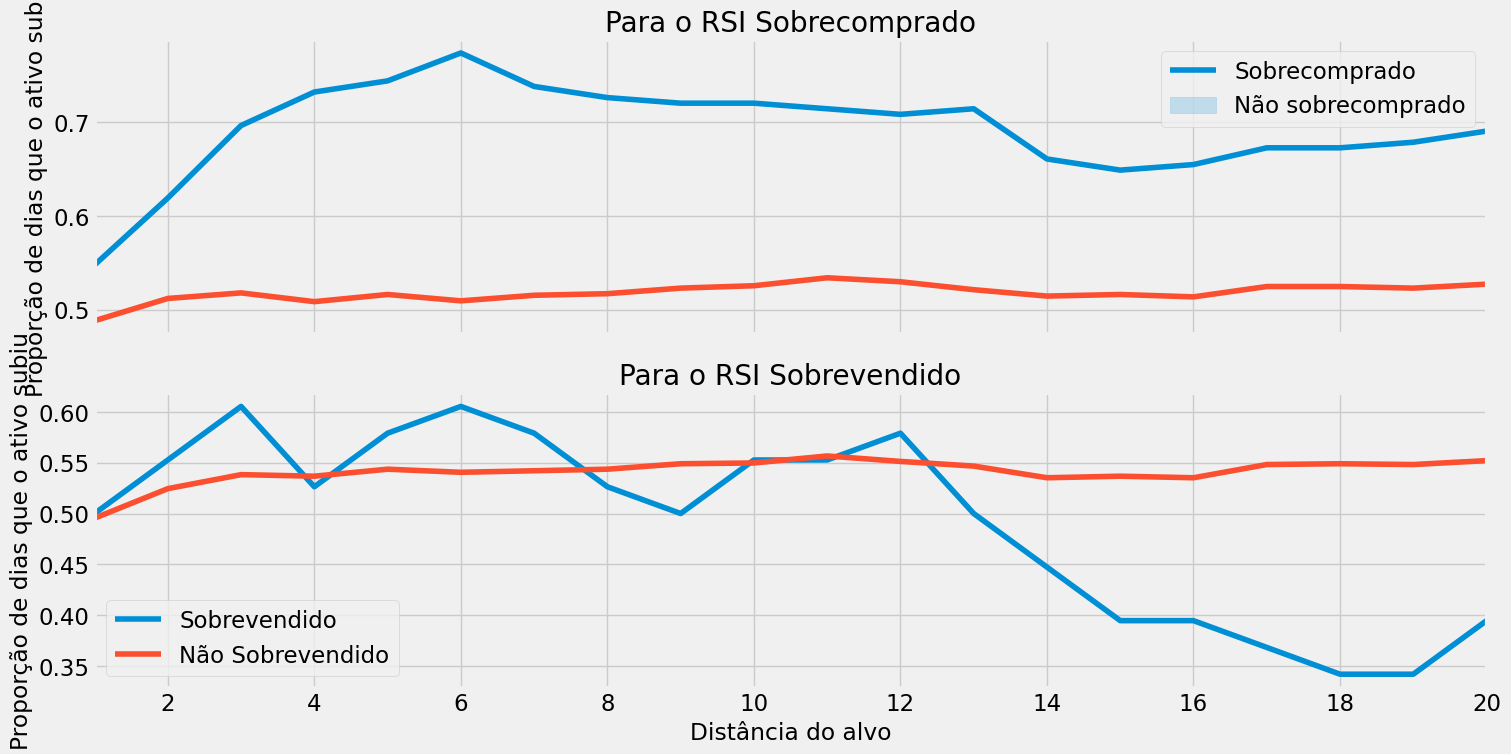

In [18]:
RSI_dist_alvo_visualizer(RSI_ALVO_CMIG3)

**Para ITUB4:**

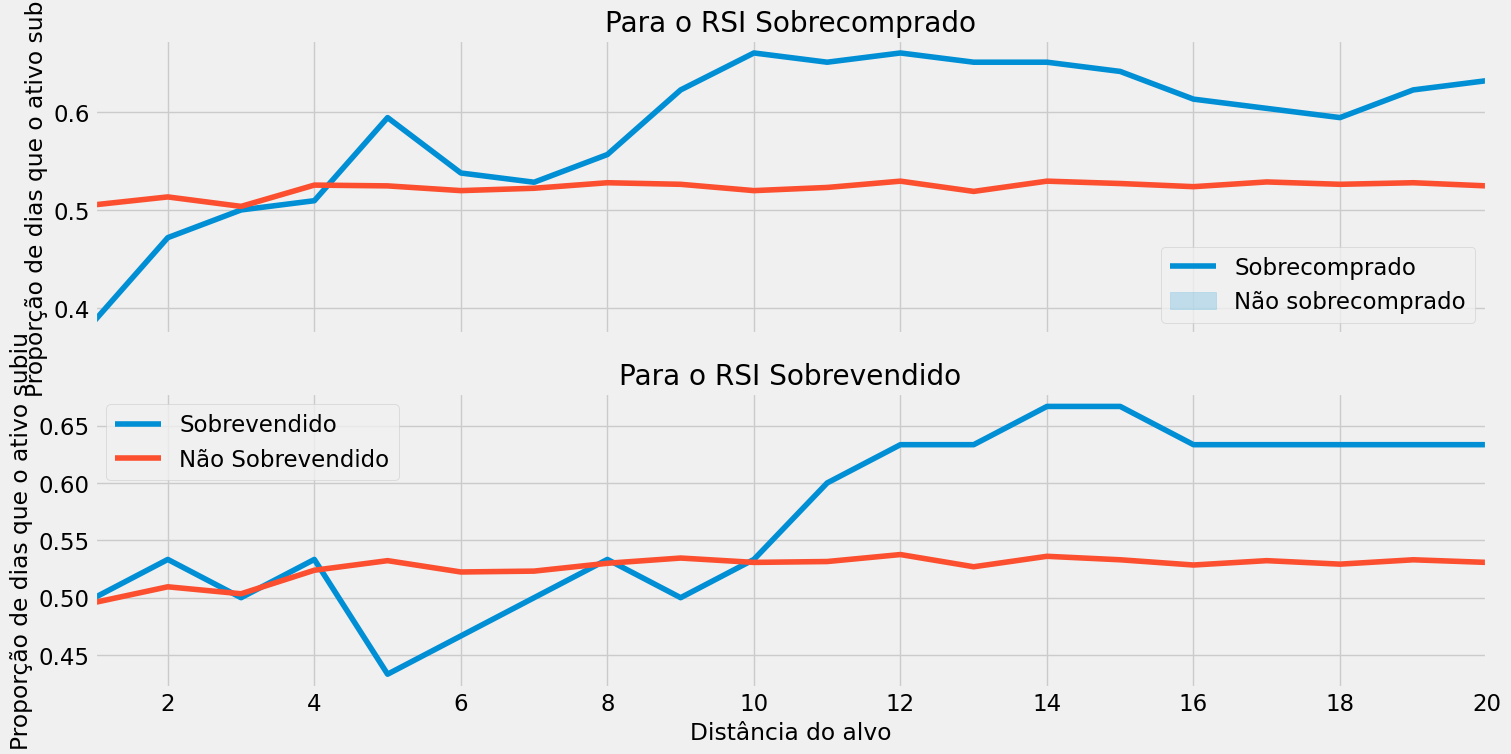

In [19]:
RSI_dist_alvo_visualizer(RSI_ALVO_ITUB4)

## Bandas de Bollinger

- As bandas de Bollinger são compostas por 3 linhas:
    - Uma média móvel simples de n períodos;
    - Uma banda superior composta pela soma de 2 desvios padrões da média de 20 períodos;
    - Uma banda inferior composta pela subtração de 2 desvios padrões da média de 20 períodos.
- É um indicador de momentum, muito usado em estratégias de reversão a média.


Para realizar o teste, verificaremos a estratégia "Fechou Fora" das bandas superior ou inferior, ou seja, quando o preço de fechameno fica abaixo da banda inferior gera um sinal de compra e acima da banda superior, um sinal de venda.

Seguiremos a mesma abordagem realizada para o RSI.

In [20]:
def BBANDS_dist_alvo_optimizer(TICKER):


    RESULTADOS = pd.DataFrame(columns=['Distancia_Alvo', 'Media_Alvo_BBAND_ForaLower', 'Media_Alvo_BBAND_DentroLower',
                                       'Media_Alvo_BBAND_ForaUpper', 'Media_Alvo_BBAND_DentroUpper'])
    for index, i in enumerate(range(1, 21)):

        df = selecionar_ativo(TICKER, DIST_ALVO=i)
        df.ta.bbands(length=10, append=True)
        df['BBAND_FechouFora_Lower'] = df['Close'] <  df[f'BBL_10_2.0']
        df['BBAND_FechouFora_Upper'] = df['Close'] >  df[f'BBU_10_2.0']
        
        bband_foralower = df.groupby('BBAND_FechouFora_Lower').agg({'Alvo': 'mean'})
        bband_foraupper = df.groupby('BBAND_FechouFora_Upper').agg({'Alvo': 'mean'})
        try:
            RESULTADOS.loc[index, 'Distancia_Alvo'] = i
            RESULTADOS.loc[index, 'Media_Alvo_BBAND_ForaLower'] = bband_foralower.loc[True, 'Alvo']
            RESULTADOS.loc[index, 'Media_Alvo_BBAND_DentroLower'] = bband_foralower.loc[False, 'Alvo']
            RESULTADOS.loc[index, 'Media_Alvo_BBAND_ForaUpper'] = bband_foraupper.loc[True, 'Alvo']
            RESULTADOS.loc[index, 'Media_Alvo_BBAND_DentroUpper'] = bband_foraupper.loc[False, 'Alvo']
        except:
            continue

    
    return RESULTADOS

def BBAND_dist_alvo_visualizer(RESULTADOS_OPTIMIZER):

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,8), sharex=True)

    sns.lineplot(
        data=RESULTADOS_OPTIMIZER,
        x='Distancia_Alvo',
        y='Media_Alvo_BBAND_ForaLower',
        ax=ax[0],
        label='Fechou fora da Banda'
    )
    sns.lineplot(
        data=RESULTADOS_OPTIMIZER,
        x='Distancia_Alvo',
        y='Media_Alvo_BBAND_DentroLower',
        ax=ax[0],
        label='Fechou dentro da Banda'
    )
    ax[0].set_title('Para banda Inferior')
    ax[0].set_ylabel('Proporção de dias que o ativo subiu')


    sns.lineplot(
        data=RESULTADOS_OPTIMIZER,
        x='Distancia_Alvo',
        y='Media_Alvo_BBAND_ForaUpper',
        ax=ax[1],
        label='Fechou fora da Banda'
    )
    sns.lineplot(
        data=RESULTADOS_OPTIMIZER,
        x='Distancia_Alvo',
        y='Media_Alvo_BBAND_DentroUpper',
        ax=ax[1],
        label='Fechou dentro da Banda'
    )
    
    ax[1].set_title('Para a banda Superior')
    ax[1].set_ylabel('Proporção de dias que o ativo subiu')
    ax[1].set_xlabel('Distância do alvo')
    ax[1].set_xticks(range(2, 21, 2))
    ax[1].set_xlim(1, 20)

In [21]:
BBAND_ALVO_PETR4 = BBANDS_dist_alvo_optimizer('PETR4.SA')
BBAND_ALVO_CMIG3 = BBANDS_dist_alvo_optimizer('CMIG3.SA')
BBAND_ALVO_ITUB4 = BBANDS_dist_alvo_optimizer('ITUB4.SA')

**Para PETR4**

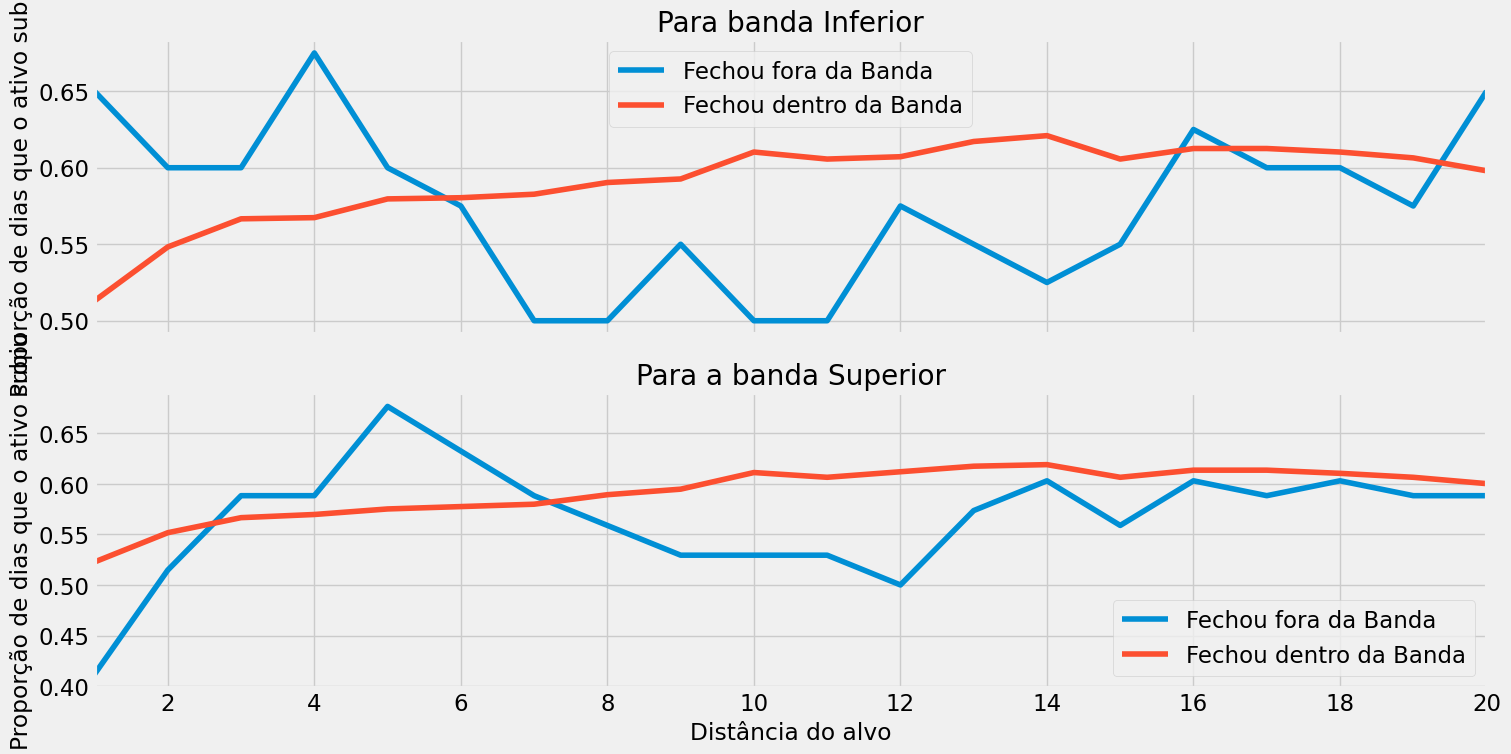

In [22]:
BBAND_dist_alvo_visualizer(BBAND_ALVO_PETR4)

**Para CMIG3**

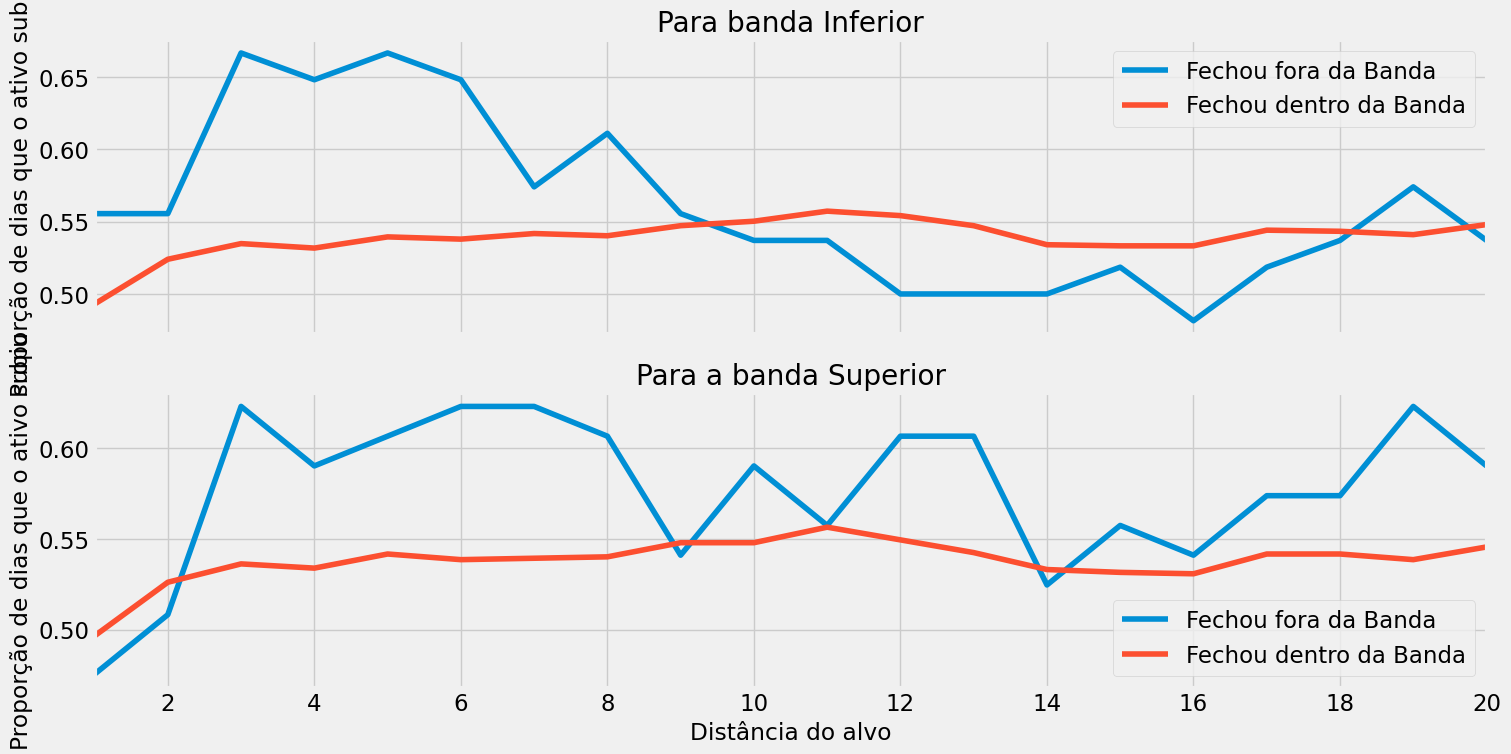

In [23]:
BBAND_dist_alvo_visualizer(BBAND_ALVO_CMIG3)

**Para ITUB4**

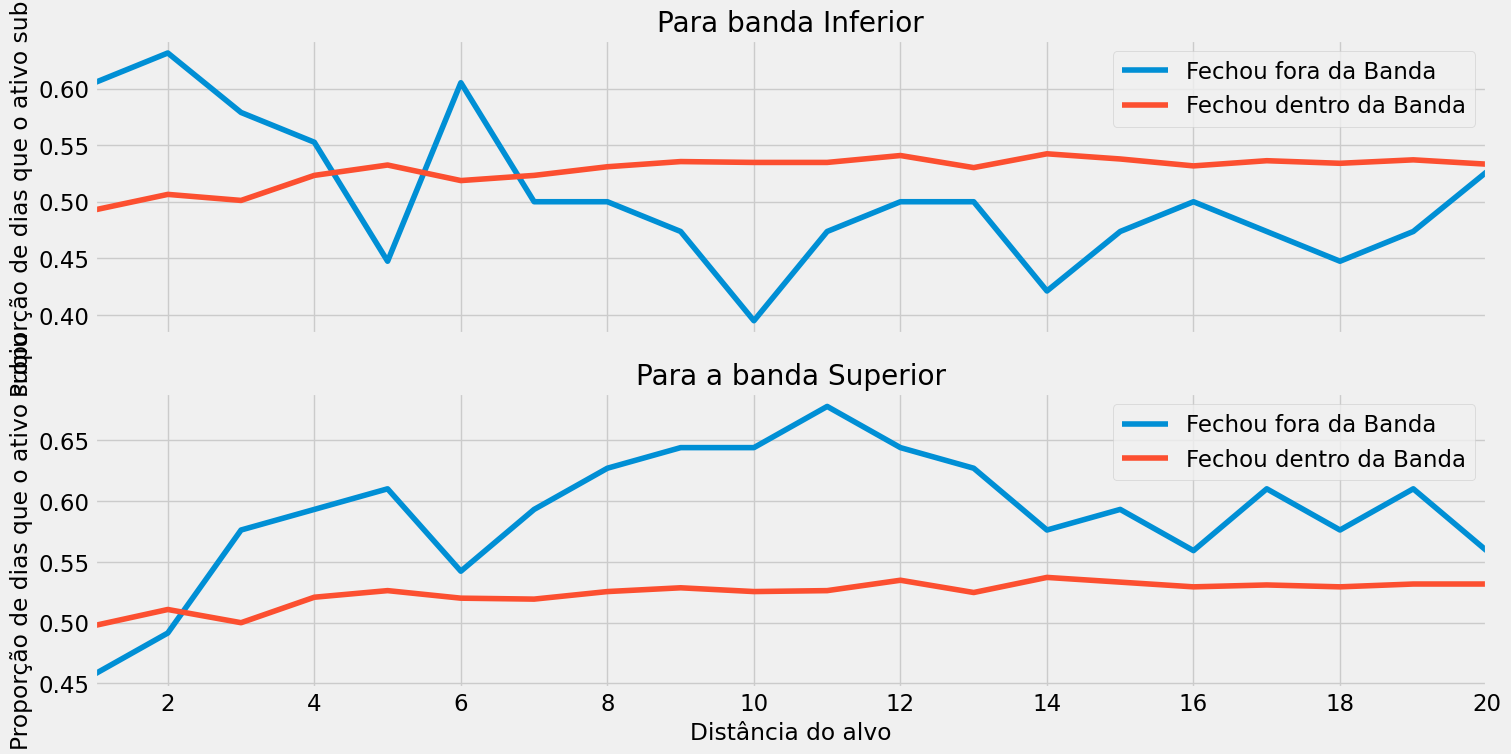

In [24]:
BBAND_dist_alvo_visualizer(BBAND_ALVO_ITUB4)

---

## Estocástico

- O estocástico é um indicador de momentum composto por 2 linhas, chamadas de rápida (%K) e lenta (%D);
    - A linha rápida é composta por uma média das máximas e mínimas de n sessões anteriores;
    - A linha lenta é composta por uma média móvel da linha rápida.

- As estratégias mais comuns utilizadas são semelhantes ao RSI, acima de 80 temos um cenário de sobrecompra, abaixo de 20 um cenário de sobrevenda.


In [25]:
def STOCH_dist_alvo_optimizer(TICKER):


    RESULTADOS = pd.DataFrame(columns=['Distancia_Alvo', 'Media_Alvo_STOCH_Sobrecomprado', 'Media_Alvo_STOCH_Nao_Sobrecomprado',
                                       'Media_Alvo_STOCH_Sobrevendido', 'Media_Alvo_STOCH_Nao_Sobrevendido'])
    for index, i in enumerate(range(1, 21)):

        df = selecionar_ativo(TICKER, DIST_ALVO=i)
        df.ta.stoch(append=True)
        df['STOCH_Sobrecomprado'] = df['STOCHd_14_3_3'] > 80
        df['STOCH_Sobrevendido'] = df['STOCHd_14_3_3'] < 20
        
        stoch_sobrecomprado = df.groupby('STOCH_Sobrecomprado').agg({'Alvo': 'mean'})
        stoch_sobrevendido = df.groupby('STOCH_Sobrevendido').agg({'Alvo': 'mean'})
        try:
            RESULTADOS.loc[index, 'Distancia_Alvo'] = i
            RESULTADOS.loc[index, 'Media_Alvo_STOCH_Sobrecomprado'] = stoch_sobrecomprado.loc[True, 'Alvo']
            RESULTADOS.loc[index, 'Media_Alvo_STOCH_Nao_Sobrecomprado'] = stoch_sobrecomprado.loc[False, 'Alvo']
            RESULTADOS.loc[index, 'Media_Alvo_STOCH_Sobrevendido'] = stoch_sobrevendido.loc[True, 'Alvo']
            RESULTADOS.loc[index, 'Media_Alvo_STOCH_Nao_Sobrevendido'] = stoch_sobrevendido.loc[False, 'Alvo']
        except:
            continue

    
    return RESULTADOS

def STOCH_dist_alvo_visualizer(RESULTADOS_OPTIMIZER):

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,8), sharex=True)

    sns.lineplot(
        data=RESULTADOS_OPTIMIZER,
        x='Distancia_Alvo',
        y='Media_Alvo_STOCH_Sobrecomprado',
        ax=ax[0],
        label='Sobrecomprado'
    )
    sns.lineplot(
        data=RESULTADOS_OPTIMIZER,
        x='Distancia_Alvo',
        y='Media_Alvo_STOCH_Nao_Sobrecomprado',
        ax=ax[0],
        label='Não sobrecomprado'
    )
    ax[0].set_title('Para o estocástico sobrecomprado')
    ax[0].set_ylabel('Proporção de dias que o ativo subiu')


    sns.lineplot(
        data=RESULTADOS_OPTIMIZER,
        x='Distancia_Alvo',
        y='Media_Alvo_STOCH_Sobrevendido',
        ax=ax[1],
        label='Sobrevendido'
    )
    sns.lineplot(
        data=RESULTADOS_OPTIMIZER,
        x='Distancia_Alvo',
        y='Media_Alvo_STOCH_Nao_Sobrevendido',
        ax=ax[1],
        label='Não sobrevendido'
    )
    
    ax[1].set_title('Para o estocástico sobrevendido')
    ax[1].set_ylabel('Proporção de dias que o ativo subiu')
    ax[1].set_xlabel('Distância do alvo')
    ax[1].set_xticks(range(2, 21, 2))
    ax[1].set_xlim(1, 20)

In [26]:
STOCH_ALVO_PETR4 = STOCH_dist_alvo_optimizer('PETR4.SA')
STOCH_ALVO_CMIG3 = STOCH_dist_alvo_optimizer('CMIG3.SA')
STOCH_ALVO_ITUB4 = STOCH_dist_alvo_optimizer('ITUB4.SA')

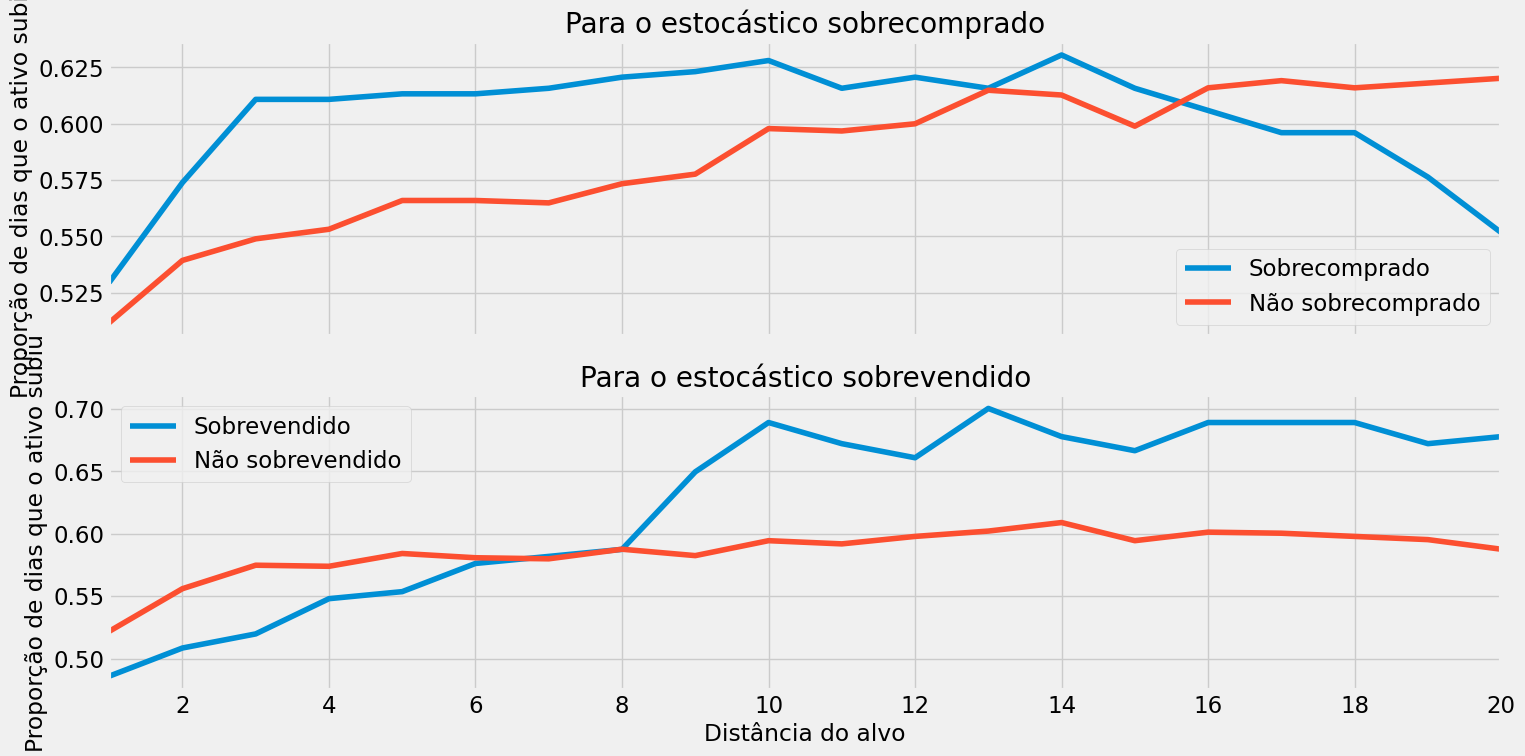

In [27]:
STOCH_dist_alvo_visualizer(STOCH_ALVO_PETR4)

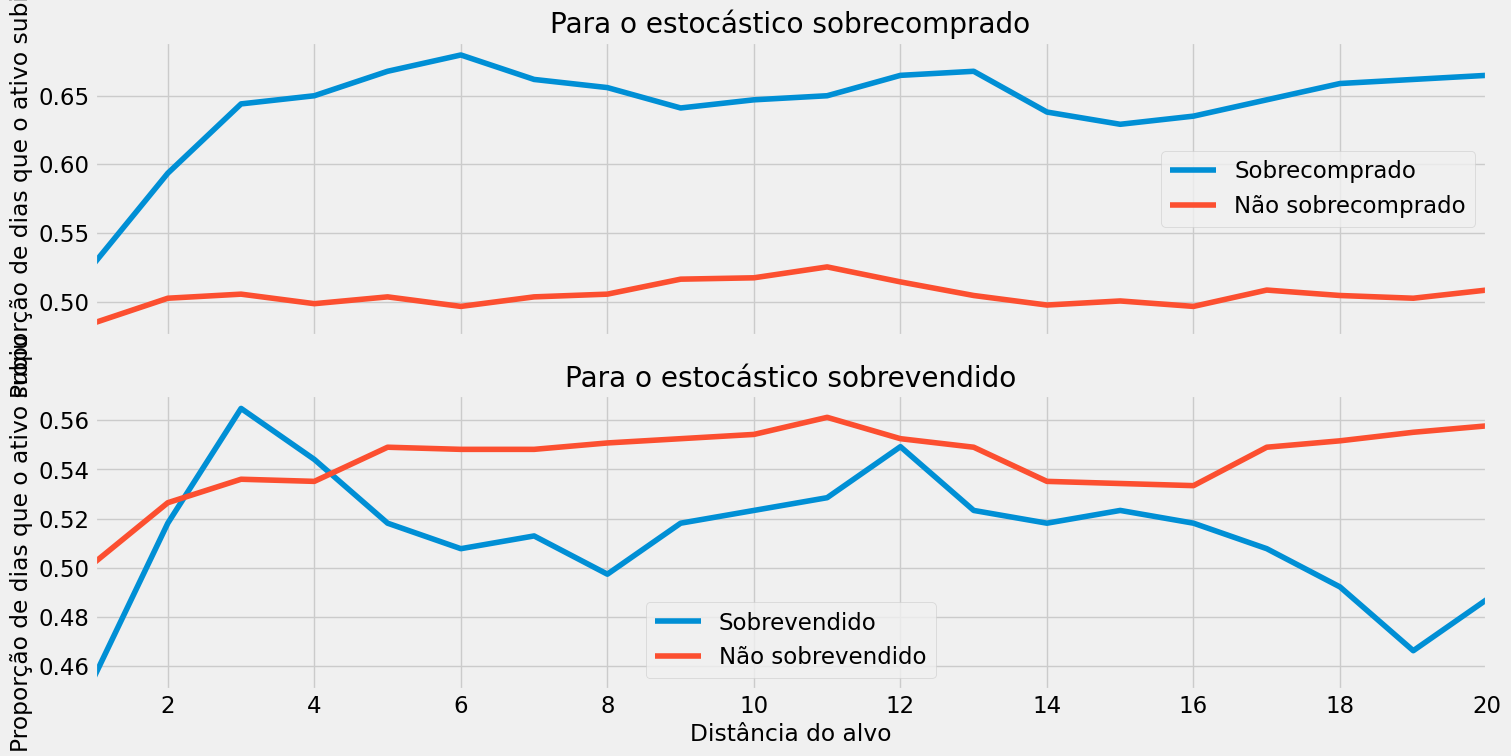

In [28]:
STOCH_dist_alvo_visualizer(STOCH_ALVO_CMIG3)

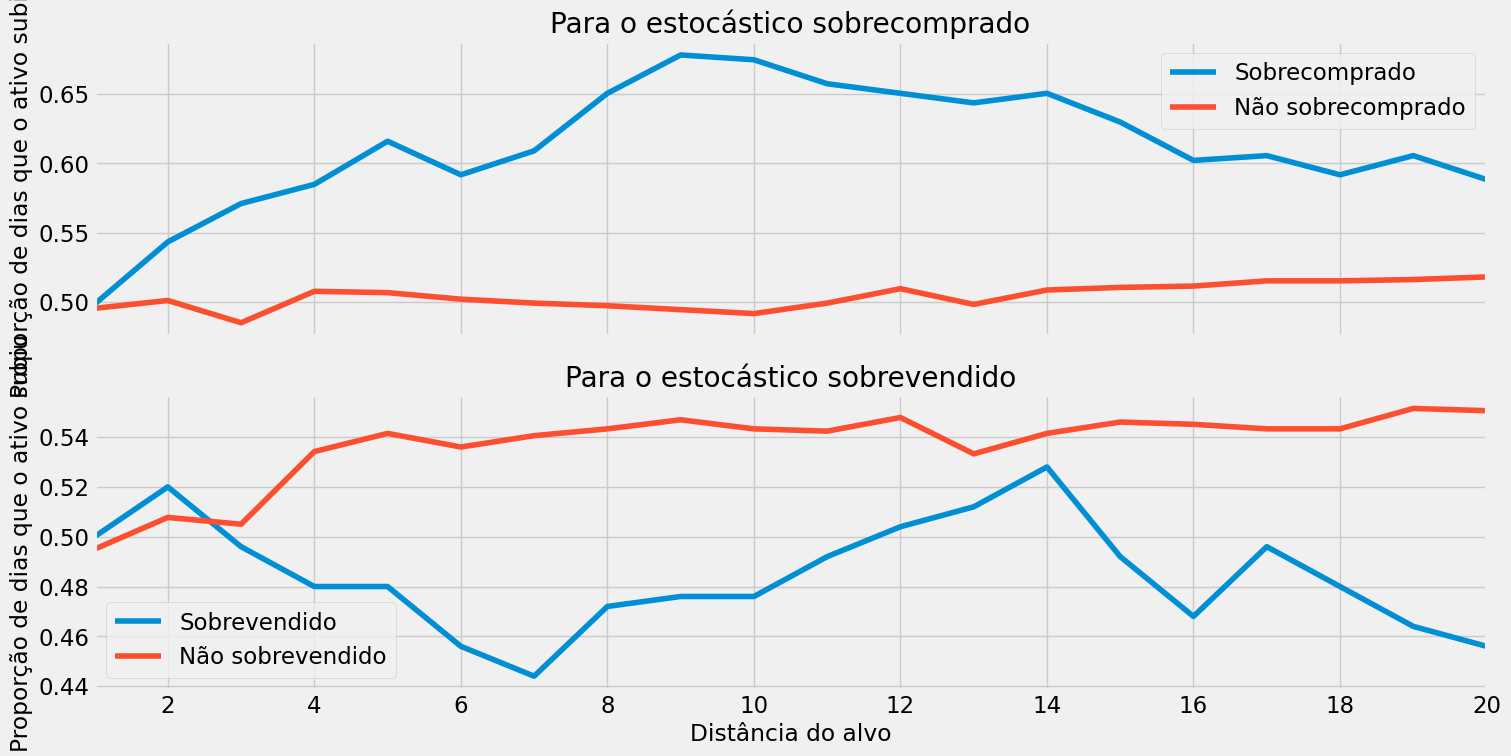

In [29]:
STOCH_dist_alvo_visualizer(STOCH_ALVO_ITUB4)

## Cruzamento de médias móveis

- A estratégia de cruzamento de médias móveis consiste no uso de duas médias, uma rápida de outra lenta, quando a rápida cruzar para cima a média móvel lenta, é um sinal de compra, quando cruzar para baixo, um sinal de venda.
- As duas médias móveis testadas serão a média móvel exponencial de 9 períodos (rápida) e a média móvel exponencial de 21 períodosssss (lenta).

In [30]:
def EMACROSS_dist_alvo_optimizer(TICKER):


    RESULTADOS = pd.DataFrame(columns=['Distancia_Alvo', 'Media_Alvo_EMACROSS_Compra', 'Media_Alvo_EMACROSS_Nao_Compra',
                                       'Media_Alvo_EMACROSS_Venda', 'Media_Alvo_EMACROSS_Nao_Venda'])
    for index, i in enumerate(range(1, 21)):

        df = selecionar_ativo(TICKER, DIST_ALVO=i)
        df.ta.ema(9, append=True)
        df.ta.ema(21, append=True)
        df = df.dropna()
        df['BUY_CROSS'] = ta.cross(df.EMA_9, df.EMA_21, asint=False)
        df['SELL_CROSS'] = ta.cross(df.EMA_21, df.EMA_9, asint=False)
        
        emacross_buy = df.groupby('BUY_CROSS').agg({'Alvo': 'mean'})
        emacross_sell = df.groupby('SELL_CROSS').agg({'Alvo': 'mean'})
        try:
            RESULTADOS.loc[index, 'Distancia_Alvo'] = i
            RESULTADOS.loc[index, 'Media_Alvo_EMACROSS_Compra'] = emacross_buy.loc[True, 'Alvo']
            RESULTADOS.loc[index, 'Media_Alvo_EMACROSS_Nao_Compra'] = emacross_buy.loc[False, 'Alvo']
            RESULTADOS.loc[index, 'Media_Alvo_EMACROSS_Venda'] = emacross_sell.loc[True, 'Alvo']
            RESULTADOS.loc[index, 'Media_Alvo_EMACROSS_Nao_Venda'] = emacross_sell.loc[False, 'Alvo']
        except:
            continue

    
    return RESULTADOS



def EMACROSS_dist_alvo_visualizer(RESULTADOS_OPTIMIZER):

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,8), sharex=True)

    sns.lineplot(
        data=RESULTADOS_OPTIMIZER,
        x='Distancia_Alvo',
        y='Media_Alvo_EMACROSS_Compra',
        ax=ax[0],
        label='Com sinal'
    )
    sns.lineplot(
        data=RESULTADOS_OPTIMIZER,
        x='Distancia_Alvo',
        y='Media_Alvo_EMACROSS_Nao_Compra',
        ax=ax[0],
        label='Sem sinal'
    )
    ax[0].set_title('Para o sinal de compra')
    ax[0].set_ylabel('Proporção de dias que o ativo subiu')


    sns.lineplot(
        data=RESULTADOS_OPTIMIZER,
        x='Distancia_Alvo',
        y='Media_Alvo_EMACROSS_Venda',
        ax=ax[1],
        label='Com sinal'
    )
    sns.lineplot(
        data=RESULTADOS_OPTIMIZER,
        x='Distancia_Alvo',
        y='Media_Alvo_EMACROSS_Nao_Venda',
        ax=ax[1],
        label='Sem sinal'
    )
    
    ax[1].set_title('Para o sinal de venda')
    ax[1].set_ylabel('Proporção de dias que o ativo subiu')
    ax[1].set_xlabel('Distância do alvo')
    ax[1].set_xticks(range(2, 21, 2))
    ax[1].set_xlim(1, 20)

In [31]:
EMA_ALVO_PETR4 = EMACROSS_dist_alvo_optimizer('PETR4.SA')
EMA_ALVO_CMIG3 = EMACROSS_dist_alvo_optimizer('CMIG3.SA')
EMA_ALVO_ITUB4 = EMACROSS_dist_alvo_optimizer('ITUB4.SA')

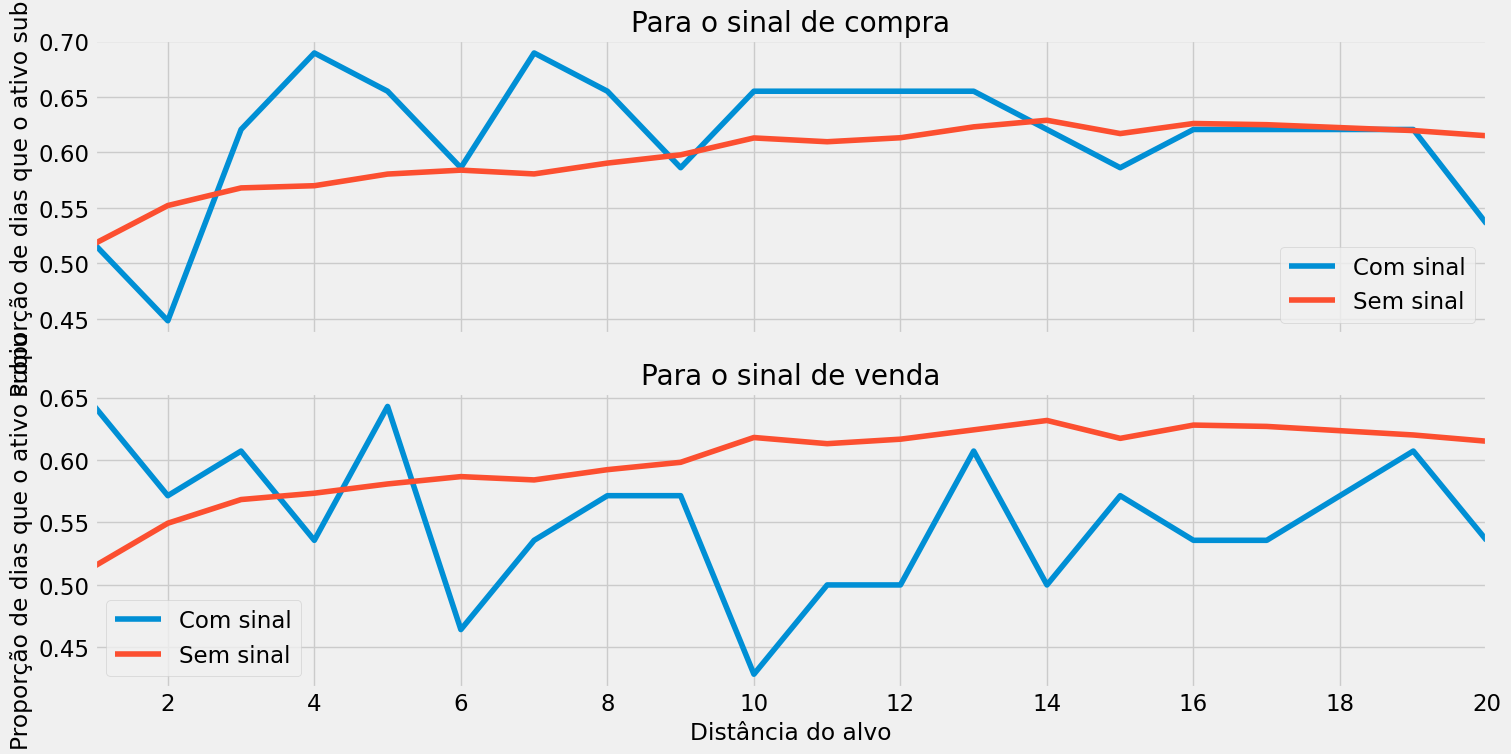

In [32]:
EMACROSS_dist_alvo_visualizer(EMA_ALVO_PETR4)

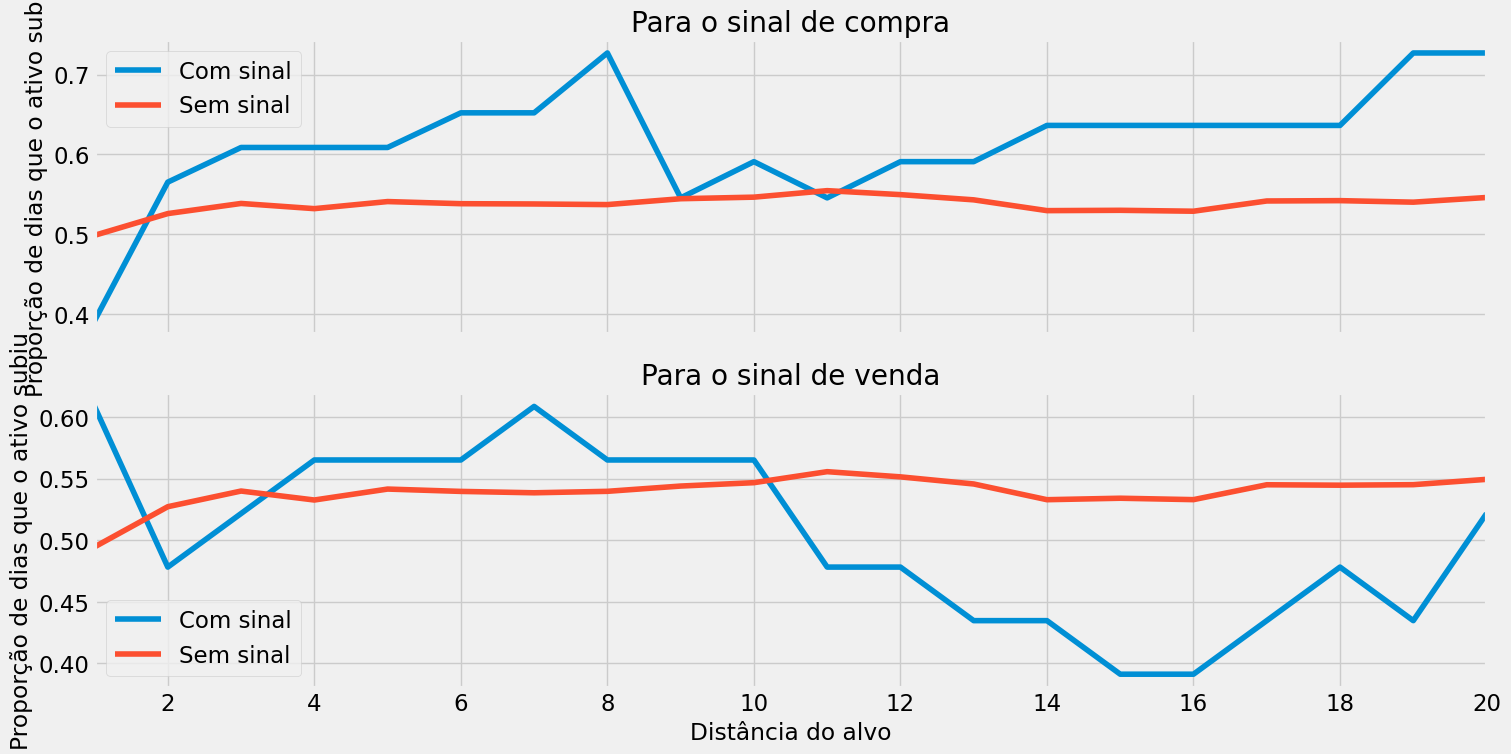

In [33]:
EMACROSS_dist_alvo_visualizer(EMA_ALVO_CMIG3)

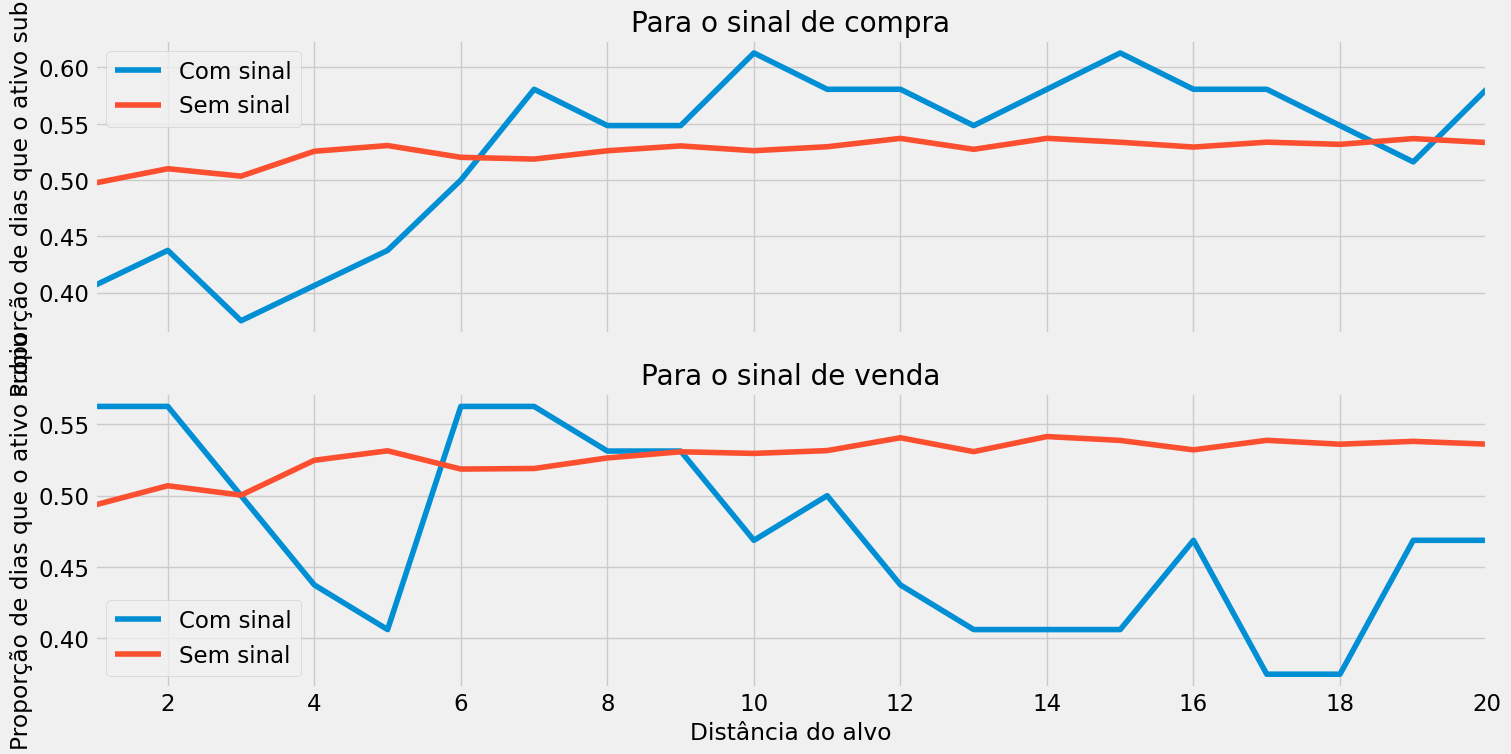

In [34]:
EMACROSS_dist_alvo_visualizer(EMA_ALVO_ITUB4)

TO-DO
- Teste relacionado a distância da média
- Teste relacionado a inclinação da média
- Teste relacionado a indicadores da WIKI
- Teste relacionado a indicadores Macro
- Teste relacionado a indicadores Forex

---

## Significância estatística dos indicadores e análises

TO-DO

- Construir funções para realizar o teste binomial entre dias com o sinal e sem o sinal.  
    -> Resta Cruzamento de Médias Móveis
- Interpretar Resultados e gerar insights  
    ->

In [35]:
def RSI_OPTIMIZER(Ticker):
    
    from scipy.stats import binomtest

    df = selecionar_ativo(Ticker, DIST_ALVO=5).query('Date < "2022-01-01"')


    resultados = pd.DataFrame(columns=['Parametro','Proporção do Alvo no Dataset', 'Proporção do Alvo com a Feature', 'PValor'])
    for i in range(0,40):

        RSI_PARAMETER = i + 1

        base_indicators = ta.Strategy(
            name="RSI_OPT",
            ta=[
                {'kind': 'rsi', 'length': RSI_PARAMETER},
            ]
        )

        df.ta.strategy(base_indicators)

        df['FLG_Sobrecomprado'] = df[f'RSI_{RSI_PARAMETER}'] > 70
        df['FLG_Sobrevendido'] = df[f'RSI_{RSI_PARAMETER}'] < 30
        df['Counter'] = 1

        rsi_group_under = df.groupby('FLG_Sobrecomprado').agg({'Counter': 'sum', 'LEAK_Retorno':'mean', 'Alvo':'sum'})

        binomialtest = binomtest(
                            k=rsi_group_under.loc[True, 'Alvo'],
                            n=rsi_group_under.loc[True, 'Counter'],
                            p=df['Alvo'].mean(),
                            alternative='greater'
                        )

        resultados.loc[i, 'Parametro'] = RSI_PARAMETER
        resultados.loc[i, 'Proporção do Alvo no Dataset'] = df['Alvo'].mean()
        resultados.loc[i, 'Proporção do Alvo com a Feature'] = df.groupby('FLG_Sobrevendido').agg({'Alvo':'mean'}).loc[True, 'Alvo']
        resultados.loc[i, 'PValor'] = binomialtest.pvalue

    return resultados
                            
    

In [36]:
def BBAND_OPTIMIZER(Ticker):
    from scipy.stats import binomtest

    df = selecionar_ativo(Ticker, DIST_ALVO=5).query('Date < "2022-01-01"')


    resultados = pd.DataFrame(columns=['Parametro','Proporção do Alvo no Dataset', 'Proporção do Alvo com a Feature', 'PValor'])
    for i in range(0,40):

        BBAND_PARAMETER = i + 1

        base_indicators = ta.Strategy(
            name="bband_OPT",
            ta=[
                {'kind': 'bbands', 'length': BBAND_PARAMETER},
            ]
        )

        df.ta.strategy(base_indicators)


        df['BBAND_FECHOUFORA_LOWER'] = df['Close'] <  df[f'BBL_{BBAND_PARAMETER}_2.0']
        df['BBAND_FECHOUFORA_UPPER'] = df['Close'] >  df[f'BBU_{BBAND_PARAMETER}_2.0']
        df['Counter'] = 1

        bband_group_under = df.groupby('BBAND_FECHOUFORA_UPPER').agg({'Counter': 'sum', 'LEAK_Retorno':'mean', 'Alvo':'sum'})
        
        try:
            binomialtest = binomtest(
                                k=bband_group_under.loc[True, 'Alvo'],
                                n=bband_group_under.loc[True, 'Counter'],
                                p=df['Alvo'].mean(),
                                alternative='greater'
                        )
        
            resultados.loc[i, 'Parametro'] = BBAND_PARAMETER
            resultados.loc[i, 'Proporção do Alvo no Dataset'] = df['Alvo'].mean()
            resultados.loc[i, 'Proporção do Alvo com a Feature'] = df.groupby('BBAND_FECHOUFORA_LOWER').agg({'Alvo':'mean'}).loc[True, 'Alvo']
            resultados.loc[i, 'PValor'] = binomialtest.pvalue
        except:
            continue

    return resultados

In [37]:
def STOCH_OPTIMIZER(Ticker):

    from scipy.stats import binomtest
    df = selecionar_ativo(Ticker, DIST_ALVO=5).query('Date < "2022-01-01"')


    resultados = pd.DataFrame(columns=['Parametro','Proporção do Alvo no Dataset', 'Entradas','Proporção do Alvo com a Feature', 'PValor'])
    for i in range(0,40):

        STOCH_PARAMETER = i + 1

        base_indicators = ta.Strategy(
            name="stoch_opt",
            ta=[
                {'kind': 'stoch', 'k': STOCH_PARAMETER},
            ]
        )

        df.ta.strategy(base_indicators)


        df['STOCH_ABAIXO'] = df[f'STOCHd_{STOCH_PARAMETER}_3_3'] < 20
        df['STOCH_ACIMA'] = df[f'STOCHd_{STOCH_PARAMETER}_3_3'] > 80
        df['Counter'] = 1

        stoch_group_under = df.groupby('STOCH_ACIMA').agg({'Counter': 'sum', 'LEAK_Retorno':'mean', 'Alvo':'sum'})
        
        try:
            binomialtest = binomtest(
                                k=stoch_group_under.loc[True, 'Alvo'],
                                n=stoch_group_under.loc[True, 'Counter'],
                                p=df['Alvo'].mean(),
                                alternative='greater'
                        )
        
            resultados.loc[i, 'Parametro'] = STOCH_PARAMETER
            resultados.loc[i, 'Entradas'] = df['STOCH_ACIMA'].sum()
            resultados.loc[i, 'Proporção do Alvo no Dataset'] = df.groupby('STOCH_ACIMA').agg({'Alvo':'mean'}).loc[False, 'Alvo']
            resultados.loc[i, 'Proporção do Alvo com a Feature'] = df.groupby('STOCH_ACIMA').agg({'Alvo':'mean'}).loc[True, 'Alvo']
            resultados.loc[i, 'PValor'] = binomialtest.pvalue
        except:
            continue

    return resultados

---

## Modelagem

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from dtreeviz.trees import *


In [39]:
def full_model_test(TICKER):

    df = selecionar_ativo(TICKER, DIST_ALVO=5)


    base_indicators = ta.Strategy(
        name="EDA",
        ta=[
            {'kind': 'rsi'},
            {'kind': 'stoch'},
            {'kind': 'roc', 'length': 2},
            {'kind': 'roc', 'length': 5},
            {'kind': 'roc', 'length': 10},
            {'kind': 'ema', 'length': 9},
            {'kind': 'ema', 'length': 21},
            {'kind': 'bbands', 'length': 10},
            {'kind': 'slope', 'length': 3},
            {'kind': 'atr', 'length': 5},
            {'kind': 'willr'},
            {'kind': 'obv'}

        ]
    )

    df.ta.strategy(base_indicators)
    df['OBV_ROC_14'] = ((df.OBV - df.OBV.rolling(14).mean())/ df.OBV.rolling(14).mean())

    df = df.dropna().reset_index(drop=True)

    df['EMA_BUY_CROSS'] = ta.cross(df.EMA_9, df.EMA_21, asint=False)
    df['EMA_SELL_CROSS'] = ta.cross(df.EMA_21, df.EMA_9, asint=False)
    df['EMA_9_DISTANCE'] = df.Close - df.EMA_9 
    df['EMA_21_DISTANCE'] = df.Close - df.EMA_21

    df['BBAND_FechouFora_Lower'] = df['Close'] <  df[f'BBL_10_2.0']
    df['BBAND_FechouFora_Upper'] = df['Close'] >  df[f'BBU_10_2.0']
    

    FEATURES = [
        'RSI_14', 
        'STOCHd_14_3_3',
        'ROC_2',
        'ROC_5',
        'ROC_10',
        'EMA_BUY_CROSS',
        'EMA_SELL_CROSS',
        'EMA_9_DISTANCE', 
        'EMA_21_DISTANCE',
        'BBAND_FechouFora_Lower', 
        'BBAND_FechouFora_Upper',
        'SLOPE_3',
        'ATRr_5',
        'WILLR_14',
        'OBV_ROC_14'
    ]
    TARGET = ['Alvo']

    train_size = int(len(df) * .85)

    X_train = df.loc[:train_size, FEATURES]
    y_train = df.loc[:train_size, TARGET]

    X_test = df.loc[train_size:, FEATURES]
    y_test = df.loc[train_size:, TARGET]

    param_grid = {
        'random_state': [42],
        'max_depth': [3, 4, 5],
        'min_samples_leaf': [None, 5, 10, 20, 50],
        'ccp_alpha': [0, 
        #.01, .02, .05
        ],
        'max_features': ['log2', 'sqrt']
    }

    grid_dt = GridSearchCV(
        DecisionTreeClassifier(),
        param_grid = param_grid,
        scoring='accuracy',
        cv=TimeSeriesSplit(4),
        n_jobs=-1
    )

    grid_dt.fit(X_train, y_train)

    display(dtreeviz(
        grid_dt.best_estimator_,
        X_train,
        np.ravel(y_train),
        FEATURES,
        TARGET,
        class_names=['Venda', 'Compra']
    ))

    y_pred = [1 if x == True else 0 for x in (grid_dt.best_estimator_.predict_proba(X_test)[:, 1] > .5)]

    resultados = df[train_size:].reset_index(drop=True)
    resultados['PREDICOES'] = y_pred
    resultados['RETORNO_MODELO'] = 1 + ((resultados['LEAK_Retorno']/5)* resultados['PREDICOES'])
    resultados['RETORNO_BNH'] = 1 + ((resultados['LEAK_Retorno']/5))
    resultados['RETORNO_ACUMULADO_MODELO'] = resultados['RETORNO_MODELO'].cumprod()
    resultados['RETORNO_ACUMULADO_BNH'] = 1 + (df['Close'] - df.loc[0, 'Close'])/df.loc[0, 'Close']

    fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10,6))
    sns.lineplot(
        y=resultados['RETORNO_ACUMULADO_MODELO'],
        x=resultados['Date'],
        ax=ax[0],
        label='Retorno do Modelo'
    )

    sns.lineplot(
        y=resultados['RETORNO_ACUMULADO_BNH'],
        x=resultados['Date'],
        ax=ax[0],
        label='Retorno Buy and Hold'
    )

    ax[0].set_ylabel('Retorno Acumulado')

    sns.scatterplot(
        y=resultados['PREDICOES'],
        x=resultados['Date'],
        ax=ax[1],
        marker='o',
        linestyle='-'
    )

    ax[1].set_ylabel('Predição')
    ax[1].set_xlabel('Data')
    ax[1].set_yticks([0, 1])
    ax[1].set_yticklabels(['Venda', 'Compra'])

    plt.show()

    return grid_dt.best_estimator_

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

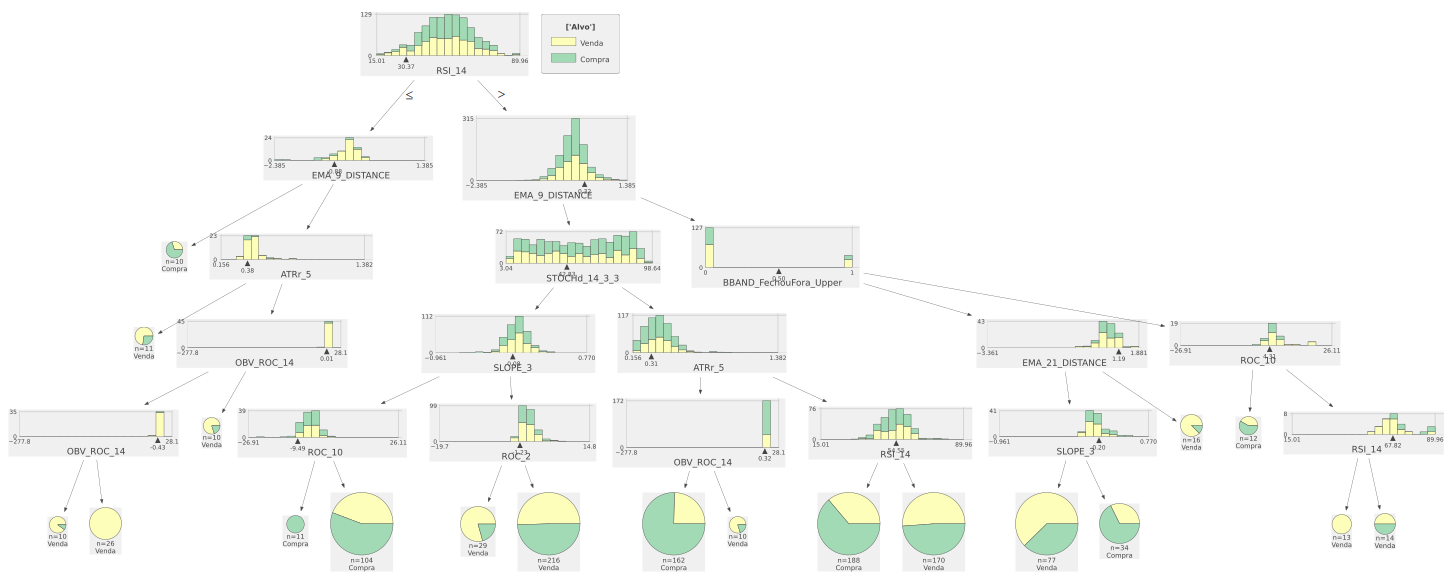

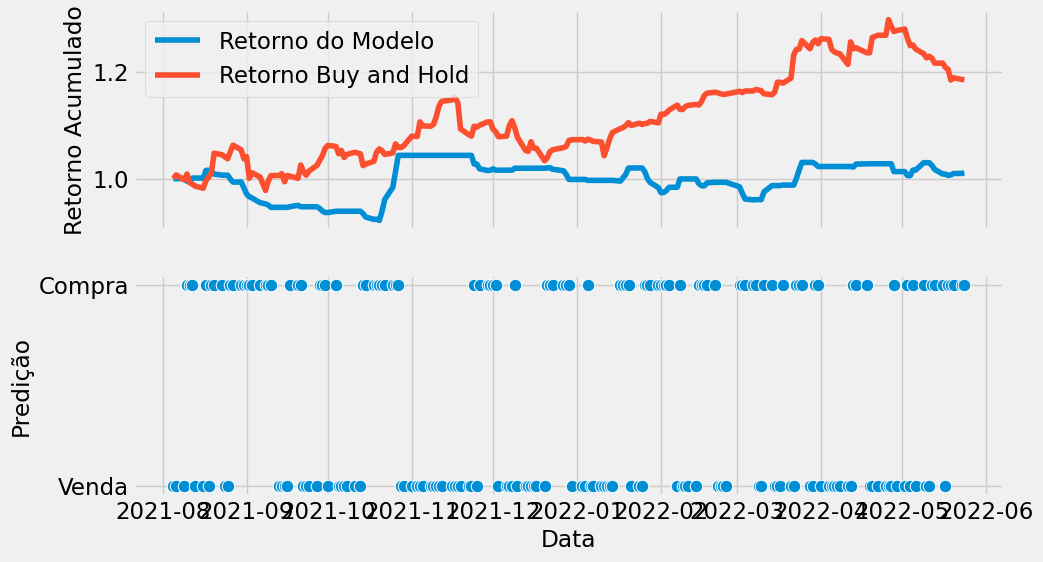

DecisionTreeClassifier(ccp_alpha=0, max_depth=5, max_features='log2',
                       min_samples_leaf=10, random_state=42)

In [40]:
full_model_test('ABEV3.SA')